In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAT
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.data import Data
import pandas as pd
from catboost import CatBoostClassifier

import networkx as nx
import pandas as pd
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

/root/HSE/2cem/SNA/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load edges
edges = pd.read_csv('../data/facebook_combined.txt', delimiter=' ', header=None)
edges = edges.values.T

# Load labels (assuming binary classification for gender)
gender_labels = []
features = []
for feat in Path("../data/facebook/").glob("*.featnames"):
    
    df = pd.read_csv(feat, sep=" ", index_col=0, header=None)
    gender_idx = df.index[df.iloc[:, 0].str.find("gender") != -1].values
    feature_names = (df[1] + df[2] + df[3].astype(str)).values

    # get label features
    df = pd.read_csv(feat.with_suffix(".feat"), sep=" ", index_col=0, header=None)
    tmp_df = pd.read_csv(feat.with_suffix(".egofeat"), sep=" ", header=None)
    tmp_df.columns = tmp_df.columns + 1
    tmp_df.index = [int(feat.stem)]
    df = pd.concat([tmp_df, df], axis=0)

    labels = df.iloc[:, gender_idx]
    gender_labels.append(labels.iloc[:, 0])
    print(f"для {feat}")
    stat_gender_collision = (labels.iloc[:, 0] != labels.iloc[:, 1]).sum() / labels.shape[0]
    print(f"количество правильных гендеров: {stat_gender_collision}")
    print()
    # иногда почему то гендер пересекается...

    df.columns = feature_names
    features.append(df)

gender_labels = pd.concat(gender_labels, axis=0)
gender_labels = gender_labels[~gender_labels.index.duplicated(keep="first")]
features = pd.concat(features, axis=0)
features = features.drop(columns=features.filter(like="gender").columns)
# features = features[~features.index.duplicated(keep="first")]
# Тут в фичах будет довольно много плохих фичей, поэтому их стоит дропнуть
good_features = features.isna().sum() 

для ../data/facebook/686.featnames
количество правильных гендеров: 0.9532163742690059

для ../data/facebook/698.featnames
количество правильных гендеров: 0.9701492537313433

для ../data/facebook/1684.featnames
количество правильных гендеров: 0.9798234552332913

для ../data/facebook/348.featnames
количество правильных гендеров: 0.9868421052631579

для ../data/facebook/3437.featnames
количество правильных гендеров: 0.9598540145985401

для ../data/facebook/107.featnames
количество правильных гендеров: 0.988527724665392

для ../data/facebook/3980.featnames
количество правильных гендеров: 0.9666666666666667

для ../data/facebook/1912.featnames
количество правильных гендеров: 0.9880952380952381

для ../data/facebook/414.featnames
количество правильных гендеров: 0.9625

для ../data/facebook/0.featnames
количество правильных гендеров: 0.9827586206896551



Text(0, 0.5, 'nan percentage')

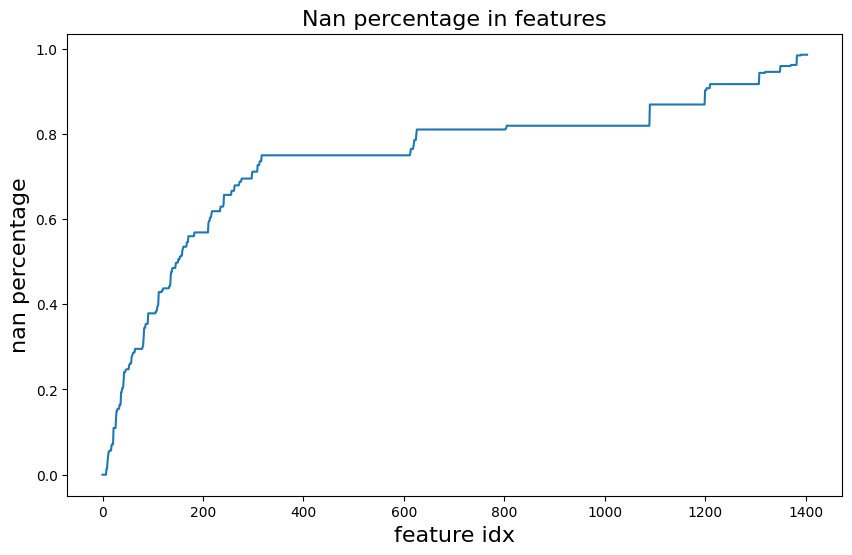

In [5]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
beb = (good_features / features.shape[0]).sort_values().reset_index(drop=True)
plt.plot(beb.index, beb.values)

# Setting the title and labels with specified size
plt.title("Nan percentage in features", fontsize=16)
plt.xlabel("feature idx", fontsize=16)
plt.ylabel("nan percentage", fontsize=16)

# (good_features / features.shape[0]).sort_values().reset_index().plot(title="Nan percentage in features", )

In [6]:
not_nan_percentage = (good_features / features.shape[0]).sort_values()
not_nan_percentage = not_nan_percentage[not_nan_percentage < 0.2]
print("Хорошие фичи, которые будут использоваться")
not_nan_percentage.index.str.split(";").str[:-1].str.join(" ").unique().tolist()

Хорошие фичи, которые будут использоваться


['education type',
 'languages id',
 'locale',
 'work end_date',
 'work start_date',
 'education concentration id',
 'education year id',
 'education degree id',
 'education school id',
 'location id',
 'work employer id',
 'birthday',
 'work location id']

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [8]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [174]:
# Load the Facebook Circles dataset and preprocess
def load_facebook_data():
    # Load edges
    edges = pd.read_csv('../data/facebook_combined.txt', delimiter=' ', header=None)
    edges = edges.values.T

    # Load labels (assuming binary classification for gender)
    gender_labels = []
    features = []
    for feat in Path("../data/facebook/").glob("*.featnames"):
        
        df = pd.read_csv(feat, sep=" ", index_col=0, header=None)
        gender_idx = df.index[df.iloc[:, 0].str.find("gender") != -1].values
        feature_names = (df[1] + df[2] + df[3].astype(str)).values

        # get label features
        df = pd.read_csv(feat.with_suffix(".feat"), sep=" ", index_col=0, header=None)
        tmp_df = pd.read_csv(feat.with_suffix(".egofeat"), sep=" ", header=None)
        tmp_df.columns = tmp_df.columns + 1
        tmp_df.index = [int(feat.stem)]
        df = pd.concat([tmp_df, df], axis=0)

        labels = df.iloc[:, gender_idx]
        gender_labels.append(labels.iloc[:, 0])
        print(f"для {feat}")
        stat_gender_collision = (labels.iloc[:, 0] != labels.iloc[:, 1]).sum() / labels.shape[0]
        print(f"количество правильных гендеров: {stat_gender_collision}")
        print()
        # иногда почему то гендер пересекается...

        df.columns = feature_names
        features.append(df)

    gender_labels = pd.concat(gender_labels, axis=0)
    gender_labels = gender_labels[~gender_labels.index.duplicated(keep="first")]
    features = pd.concat(features, axis=0)
    features = features[~features.index.duplicated(keep="first")]
    # Тут в фичах будет довольно много плохих фичей, поэтому их стоит дропнуть
    good_features = features.isna().sum() 
    # good_features = good_features[(good_features / features.shape[0]) < 0.8].index
    # features = features[good_features].fillna(0)
    features = features.fillna(0)
    features = features.drop(columns=features.filter(like="gender").columns)

    gender_labels = torch.tensor(gender_labels.sort_index().values)
    features_names = features.columns
    features = torch.tensor(features.sort_index().values, dtype=torch.float32)
    edge_index = torch.tensor(edges, dtype=torch.long)

    return features, edge_index, gender_labels, features_names

### Define model

In [92]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
        )
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.proj(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [68]:
# Define the GAT model
class GAT_model(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT_model, self).__init__()
        self.proj = torch.nn.Sequential(
            torch.nn.Linear(in_channels, hidden_channels),
            torch.nn.ReLU(),
        )
        self.gat = GAT(hidden_channels, hidden_channels, 3, out_channels=out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.proj(x)
        return F.log_softmax(self.gat(x, edge_index), dim=1)

## Test with random feature vectors for nodes

In [175]:
# Prepare the data
features, edge_index, labels, features_names = load_facebook_data()
# features can be random
random_features = torch.randn(labels.shape[0], 32)  # 16-dim node features

data = Data(x=random_features, edge_index=edge_index, y=labels)

# Split the data into train and test sets
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * data.num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask


для ../data/facebook/686.featnames
количество правильных гендеров: 0.9532163742690059

для ../data/facebook/698.featnames
количество правильных гендеров: 0.9701492537313433

для ../data/facebook/1684.featnames
количество правильных гендеров: 0.9798234552332913

для ../data/facebook/348.featnames
количество правильных гендеров: 0.9868421052631579

для ../data/facebook/3437.featnames
количество правильных гендеров: 0.9598540145985401

для ../data/facebook/107.featnames
количество правильных гендеров: 0.988527724665392

для ../data/facebook/3980.featnames
количество правильных гендеров: 0.9666666666666667

для ../data/facebook/1912.featnames
количество правильных гендеров: 0.9880952380952381

для ../data/facebook/414.featnames
количество правильных гендеров: 0.9625

для ../data/facebook/0.featnames
количество правильных гендеров: 0.9827586206896551



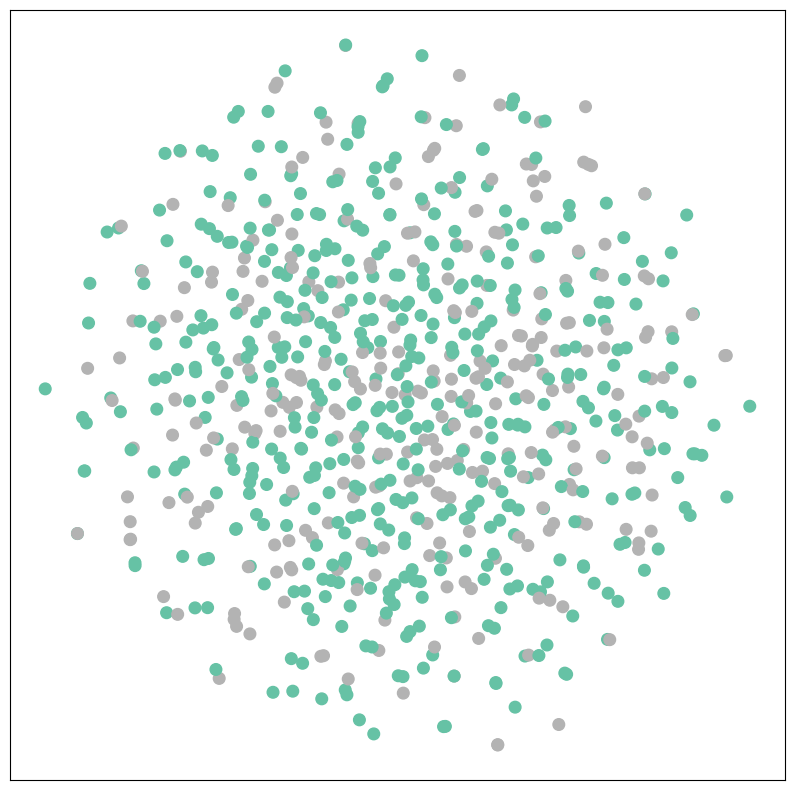

In [102]:
color = labels[data.test_mask]
visualize(data.x[data.test_mask], color)

### GCN MODEL

In [136]:
results_df = {}

In [137]:
# Initialize the model, optimizer, and loss function
model = GCN(in_channels=32, hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
data.to(device)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(100):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GCN+random features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.7482, Test RocAuc: 0.4894, Train RocAuc: 0.4963
Epoch 10, Loss: 0.6583, Test RocAuc: 0.4961, Train RocAuc: 0.5696
Epoch 20, Loss: 0.6514, Test RocAuc: 0.5029, Train RocAuc: 0.5942
Epoch 30, Loss: 0.6430, Test RocAuc: 0.4994, Train RocAuc: 0.6172
Epoch 40, Loss: 0.6352, Test RocAuc: 0.5105, Train RocAuc: 0.6403
Epoch 50, Loss: 0.6322, Test RocAuc: 0.5364, Train RocAuc: 0.6505
Epoch 60, Loss: 0.6247, Test RocAuc: 0.5610, Train RocAuc: 0.6651
Epoch 70, Loss: 0.6162, Test RocAuc: 0.5634, Train RocAuc: 0.6839
Epoch 80, Loss: 0.6121, Test RocAuc: 0.5752, Train RocAuc: 0.6907
Epoch 90, Loss: 0.6026, Test RocAuc: 0.5757, Train RocAuc: 0.7016
Final Test RocAUC: 0.568818265561258
Best Test RocAUC: 0.5765232267403606


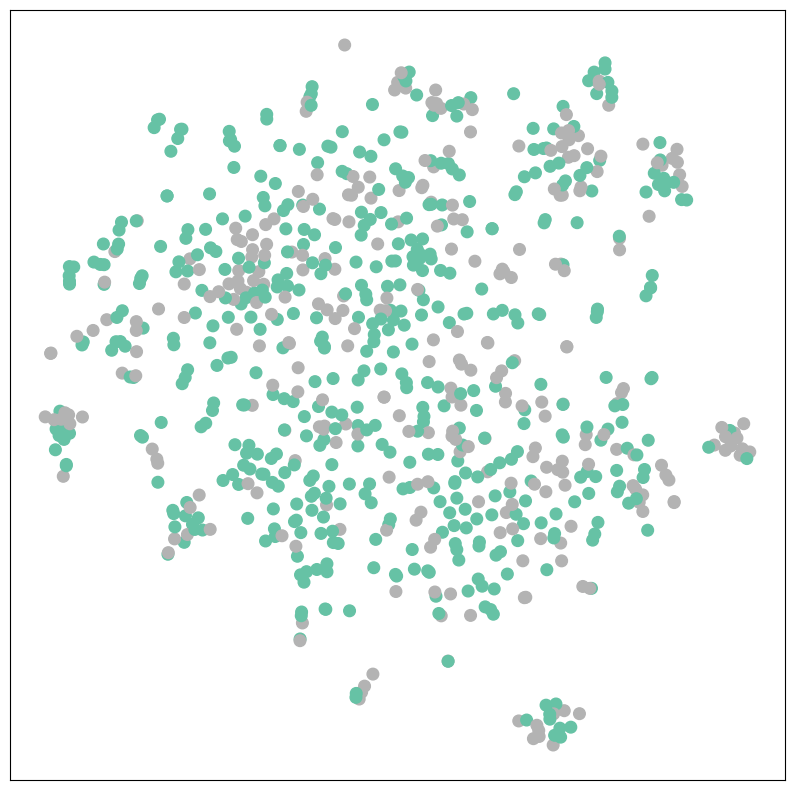

In [18]:
color = labels[data.test_mask]
x = model.proj(data.x)
embs = model.conv1(x, data.edge_index)[data.test_mask]
visualize(embs, color)

In [138]:
### GAT MODEL

# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(100):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GAT+random features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.6797, Test RocAuc: 0.5051, Train RocAuc: 0.4804
Epoch 10, Loss: 0.6604, Test RocAuc: 0.5387, Train RocAuc: 0.5961
Epoch 20, Loss: 0.6463, Test RocAuc: 0.5310, Train RocAuc: 0.6209
Epoch 30, Loss: 0.6379, Test RocAuc: 0.5001, Train RocAuc: 0.6335
Epoch 40, Loss: 0.6269, Test RocAuc: 0.5005, Train RocAuc: 0.6591
Epoch 50, Loss: 0.6212, Test RocAuc: 0.5220, Train RocAuc: 0.6812
Epoch 60, Loss: 0.6080, Test RocAuc: 0.5188, Train RocAuc: 0.6983
Epoch 70, Loss: 0.6009, Test RocAuc: 0.5188, Train RocAuc: 0.7153
Epoch 80, Loss: 0.5832, Test RocAuc: 0.5078, Train RocAuc: 0.7329
Epoch 90, Loss: 0.5793, Test RocAuc: 0.5016, Train RocAuc: 0.7428
Final Test RocAUC: 0.5075273062245031
Best Test RocAUC: 0.5483024082116068


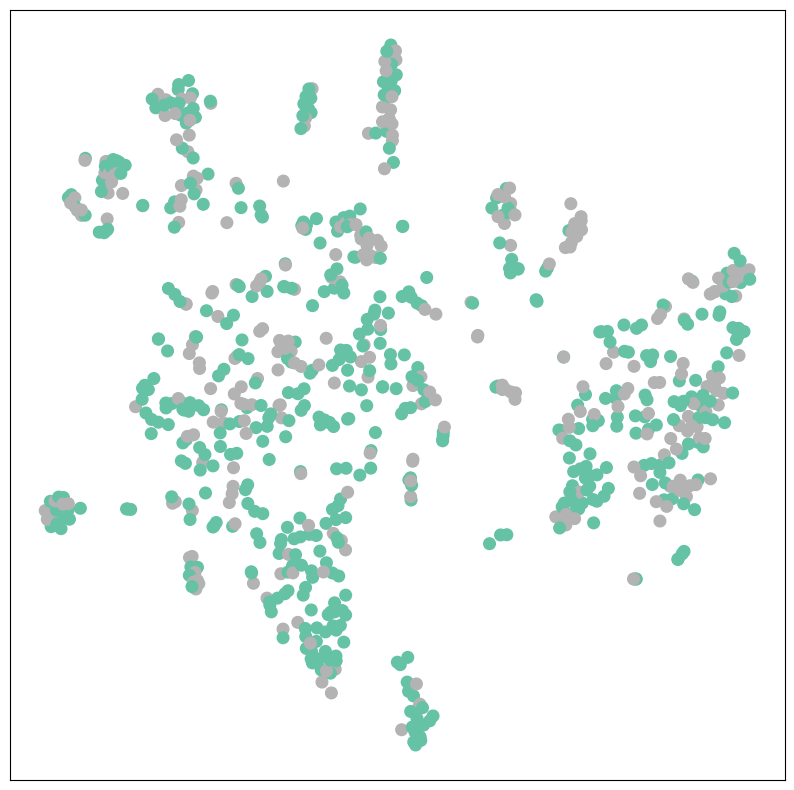

In [26]:
color = labels[data.test_mask.cpu()]
x, edge_index = data.x, data.edge_index
x = model.proj(x)
for idx, module in enumerate(model.gat.children()):
    if idx == 2:
        embs = module[0](x, edge_index)
        embs = module[1](embs, edge_index)
        break
embs = embs[data.test_mask]
visualize(embs, color)

### Now test with features, extracted from dataset

In [139]:
data.x=features
data.to(device)

Data(x=[4039, 1404], edge_index=[2, 88234], y=[4039], train_mask=[4039], test_mask=[4039])

In [145]:
# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(200):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GCN+dataset features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.7013, Test RocAuc: 0.5028, Train RocAuc: 0.5111
Epoch 10, Loss: 0.6317, Test RocAuc: 0.6005, Train RocAuc: 0.6480
Epoch 20, Loss: 0.6157, Test RocAuc: 0.6036, Train RocAuc: 0.6843
Epoch 30, Loss: 0.5972, Test RocAuc: 0.6004, Train RocAuc: 0.7137
Epoch 40, Loss: 0.5892, Test RocAuc: 0.6025, Train RocAuc: 0.7250
Epoch 50, Loss: 0.5857, Test RocAuc: 0.5970, Train RocAuc: 0.7392
Epoch 60, Loss: 0.5680, Test RocAuc: 0.5990, Train RocAuc: 0.7511
Epoch 70, Loss: 0.5677, Test RocAuc: 0.6014, Train RocAuc: 0.7499
Epoch 80, Loss: 0.5749, Test RocAuc: 0.6050, Train RocAuc: 0.7492
Epoch 90, Loss: 0.5679, Test RocAuc: 0.6033, Train RocAuc: 0.7567
Epoch 100, Loss: 0.5598, Test RocAuc: 0.5972, Train RocAuc: 0.7679
Epoch 110, Loss: 0.5562, Test RocAuc: 0.5980, Train RocAuc: 0.7705
Epoch 120, Loss: 0.5535, Test RocAuc: 0.5959, Train RocAuc: 0.7739
Epoch 130, Loss: 0.5596, Test RocAuc: 0.5965, Train RocAuc: 0.7691
Epoch 140, Loss: 0.5501, Test RocAuc: 0.6009, Train RocAuc: 0.7856
Epoch 

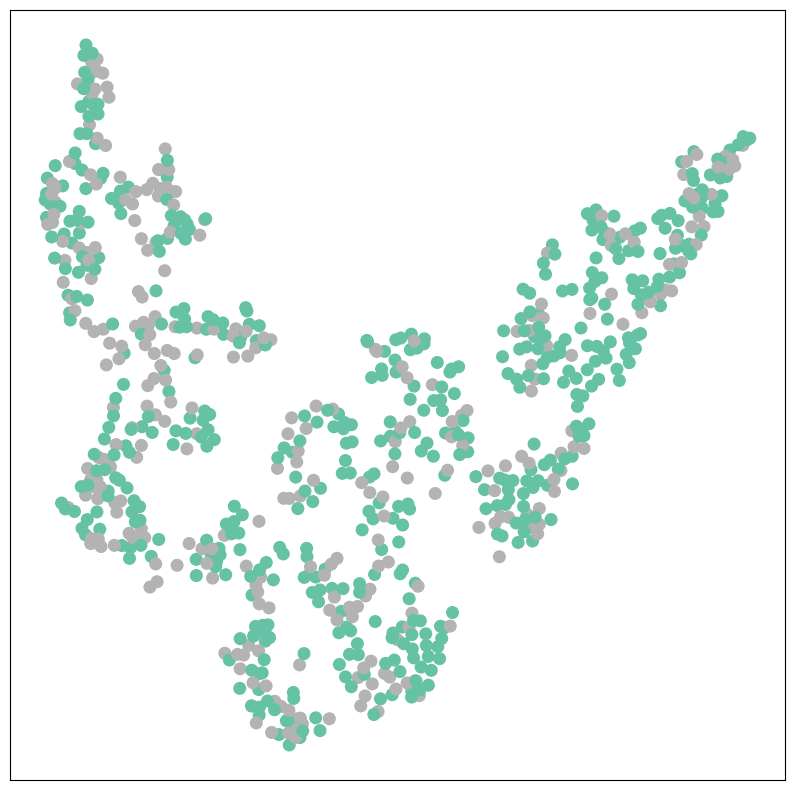

In [146]:
color = labels[data.test_mask.cpu()]
x = model.proj(data.x)
embs = model.conv1(x, data.edge_index)[data.test_mask]
visualize(embs, color)

### Test GAT model

In [141]:
# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(300):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GAT+dataset features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.6882, Test RocAuc: 0.4964, Train RocAuc: 0.4797
Epoch 10, Loss: 0.6337, Test RocAuc: 0.5654, Train RocAuc: 0.6414
Epoch 20, Loss: 0.6173, Test RocAuc: 0.5491, Train RocAuc: 0.6742
Epoch 30, Loss: 0.6059, Test RocAuc: 0.5482, Train RocAuc: 0.6966
Epoch 40, Loss: 0.5963, Test RocAuc: 0.5413, Train RocAuc: 0.7193
Epoch 50, Loss: 0.5953, Test RocAuc: 0.5334, Train RocAuc: 0.7350
Epoch 60, Loss: 0.5669, Test RocAuc: 0.5366, Train RocAuc: 0.7514
Epoch 70, Loss: 0.5652, Test RocAuc: 0.5382, Train RocAuc: 0.7612
Epoch 80, Loss: 0.5490, Test RocAuc: 0.5424, Train RocAuc: 0.7750
Epoch 90, Loss: 0.5630, Test RocAuc: 0.5326, Train RocAuc: 0.7732
Epoch 100, Loss: 0.5393, Test RocAuc: 0.5502, Train RocAuc: 0.7889
Epoch 110, Loss: 0.5182, Test RocAuc: 0.5505, Train RocAuc: 0.8031
Epoch 120, Loss: 0.5259, Test RocAuc: 0.5605, Train RocAuc: 0.8052
Epoch 130, Loss: 0.5034, Test RocAuc: 0.5660, Train RocAuc: 0.8193
Epoch 140, Loss: 0.4957, Test RocAuc: 0.5699, Train RocAuc: 0.8241
Epoch 

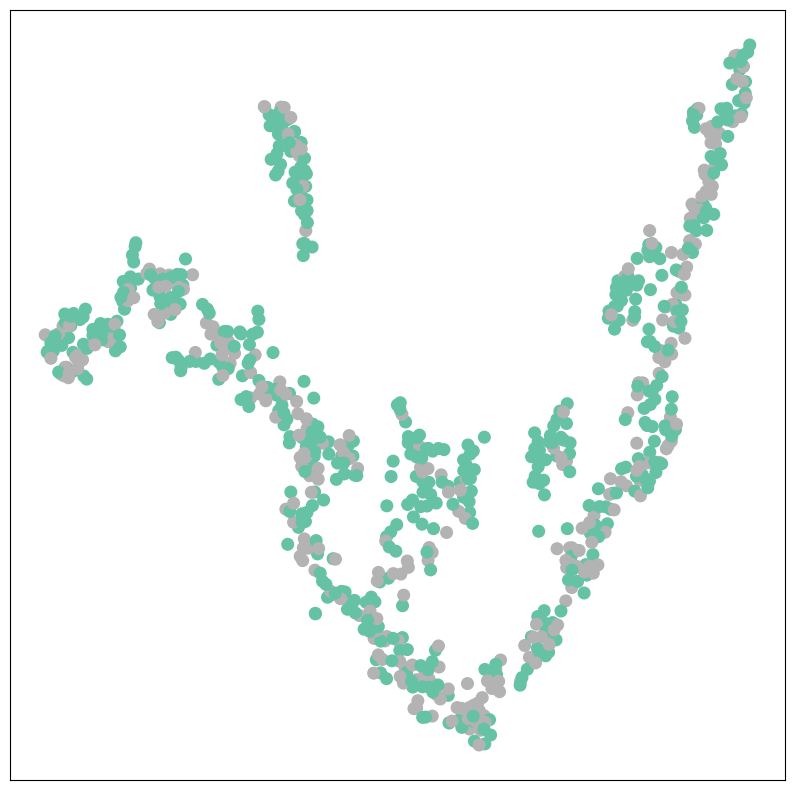

In [143]:
color = labels[data.test_mask.cpu()]
x, edge_index = data.x, data.edge_index
x = model.proj(x)
for idx, module in enumerate(model.gat.children()):
    if idx == 2:
        embs = module[0](x, edge_index)
        embs = module[1](embs, edge_index)
        break
embs = embs[data.test_mask]
visualize(embs, color)

### Try to improve GAT model

In [37]:
edges = data.edge_index.cpu().numpy().T
G = nx.Graph()
G.add_edges_from(edges)

In [38]:
# Degree Centrality
print(1)
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree_centrality')

# Closeness Centrality
print(2)
closeness_centrality = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_centrality, 'closeness_centrality')

# Betweenness Centrality
print(3)
betweenness_centrality = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness_centrality')

# get features
centrality_features = pd.DataFrame([G.nodes[node] for node in range(len(G.nodes))])


1
2
3


In [147]:
data.x=torch.concat([features, torch.tensor(centrality_features.values)], dim=1).float()
data.to(device)

Data(x=[4039, 1407], edge_index=[2, 88234], y=[4039], train_mask=[4039], test_mask=[4039])

In [148]:
# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(200):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GAT+dataset features + cardinality"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.6921, Test RocAuc: 0.4911, Train RocAuc: 0.4441
Epoch 10, Loss: 0.6461, Test RocAuc: 0.5429, Train RocAuc: 0.6278
Epoch 20, Loss: 0.6393, Test RocAuc: 0.5616, Train RocAuc: 0.6371
Epoch 30, Loss: 0.6277, Test RocAuc: 0.5375, Train RocAuc: 0.6583
Epoch 40, Loss: 0.6172, Test RocAuc: 0.5300, Train RocAuc: 0.6940
Epoch 50, Loss: 0.6019, Test RocAuc: 0.5453, Train RocAuc: 0.7113
Epoch 60, Loss: 0.5836, Test RocAuc: 0.5425, Train RocAuc: 0.7291
Epoch 70, Loss: 0.6047, Test RocAuc: 0.5423, Train RocAuc: 0.7403
Epoch 80, Loss: 0.5740, Test RocAuc: 0.5379, Train RocAuc: 0.7532
Epoch 90, Loss: 0.5557, Test RocAuc: 0.5351, Train RocAuc: 0.7728
Epoch 100, Loss: 0.5420, Test RocAuc: 0.5339, Train RocAuc: 0.7847
Epoch 110, Loss: 0.5437, Test RocAuc: 0.5312, Train RocAuc: 0.7852
Epoch 120, Loss: 0.5353, Test RocAuc: 0.5357, Train RocAuc: 0.7923
Epoch 130, Loss: 0.5218, Test RocAuc: 0.5322, Train RocAuc: 0.8110
Epoch 140, Loss: 0.5072, Test RocAuc: 0.5389, Train RocAuc: 0.8147
Epoch 

## Craft features from node2vec

In [44]:
import pickle
if not Path("../data/n2v_embs.pcl").exists():
    # Prepare the graph
    G = nx.from_edgelist(data.edge_index.cpu().numpy().T)

    # Apply Node2Vec
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model_nv = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Extract node embeddings
    node_embeddings = {node: model_nv.wv[node] for node in G.nodes()}

    n2v_embs = [node_embeddings[idx] for idx in range(4039)]
    with open("../data/n2v_embs.pcl", "wb") as f:
        pickle.dump(np.vstack(n2v_embs), f)
    n2v_embs = np.vstack(n2v_embs)
else:
    with open("../data/n2v_embs.pcl", "rb") as f:
        n2v_embs = pickle.load(f)

### GCN model

In [149]:
data.x=torch.tensor(np.vstack(n2v_embs), dtype=torch.float32)
data.to(device)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(200):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GCN+node2vec features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.7022, Test RocAuc: 0.5108, Train RocAuc: 0.4780
Epoch 10, Loss: 0.6690, Test RocAuc: 0.4750, Train RocAuc: 0.5007
Epoch 20, Loss: 0.6620, Test RocAuc: 0.5090, Train RocAuc: 0.5438
Epoch 30, Loss: 0.6508, Test RocAuc: 0.5560, Train RocAuc: 0.6016
Epoch 40, Loss: 0.6437, Test RocAuc: 0.5514, Train RocAuc: 0.6275
Epoch 50, Loss: 0.6418, Test RocAuc: 0.5783, Train RocAuc: 0.6395
Epoch 60, Loss: 0.6373, Test RocAuc: 0.5674, Train RocAuc: 0.6483
Epoch 70, Loss: 0.6335, Test RocAuc: 0.5820, Train RocAuc: 0.6533
Epoch 80, Loss: 0.6300, Test RocAuc: 0.5719, Train RocAuc: 0.6592
Epoch 90, Loss: 0.6288, Test RocAuc: 0.5642, Train RocAuc: 0.6652
Epoch 100, Loss: 0.6245, Test RocAuc: 0.5547, Train RocAuc: 0.6771
Epoch 110, Loss: 0.6217, Test RocAuc: 0.5491, Train RocAuc: 0.6829
Epoch 120, Loss: 0.6175, Test RocAuc: 0.5466, Train RocAuc: 0.6840
Epoch 130, Loss: 0.6179, Test RocAuc: 0.5431, Train RocAuc: 0.6907
Epoch 140, Loss: 0.6120, Test RocAuc: 0.5385, Train RocAuc: 0.6955
Epoch 

In [150]:
# Initialize the model, optimizer, and loss function
model = GAT_model(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    with torch.no_grad():
        logits = out
        test_mask = data.train_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())

    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item(), roc_auc

def test():
    model.eval()
    with torch.no_grad():
        logits = model(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
        roc_auc = roc_auc_score(data.y[test_mask].cpu().numpy(), F.softmax(logits[test_mask], dim=1)[:, 1].cpu().numpy())
    return acc, roc_auc

# Train the model
best_roc_auc = -1
best_accuracy = -1
for epoch in range(200):
    loss, roc_auc_train = train()
    acc, roc_auc = test()
    best_roc_auc = max(roc_auc, best_roc_auc)
    best_accuracy = max(acc, best_accuracy)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test RocAuc: {roc_auc:.4f}, Train RocAuc: {roc_auc_train:.4f}')

results_df["GAT+node2vec features"] = {"accuracy": best_accuracy, "roc auc score": best_roc_auc}
print('Final Test RocAUC:', roc_auc)
print('Best Test RocAUC:', best_roc_auc)

Epoch 0, Loss: 0.6946, Test RocAuc: 0.4349, Train RocAuc: 0.4910
Epoch 10, Loss: 0.6655, Test RocAuc: 0.4360, Train RocAuc: 0.5482
Epoch 20, Loss: 0.6615, Test RocAuc: 0.5191, Train RocAuc: 0.5886
Epoch 30, Loss: 0.6552, Test RocAuc: 0.5388, Train RocAuc: 0.5957
Epoch 40, Loss: 0.6468, Test RocAuc: 0.5876, Train RocAuc: 0.6166
Epoch 50, Loss: 0.6418, Test RocAuc: 0.6000, Train RocAuc: 0.6286
Epoch 60, Loss: 0.6385, Test RocAuc: 0.6041, Train RocAuc: 0.6403
Epoch 70, Loss: 0.6346, Test RocAuc: 0.5997, Train RocAuc: 0.6486
Epoch 80, Loss: 0.6315, Test RocAuc: 0.5956, Train RocAuc: 0.6540
Epoch 90, Loss: 0.6297, Test RocAuc: 0.5887, Train RocAuc: 0.6603
Epoch 100, Loss: 0.6282, Test RocAuc: 0.5798, Train RocAuc: 0.6638
Epoch 110, Loss: 0.6297, Test RocAuc: 0.5752, Train RocAuc: 0.6718
Epoch 120, Loss: 0.6258, Test RocAuc: 0.5702, Train RocAuc: 0.6726
Epoch 130, Loss: 0.6207, Test RocAuc: 0.5685, Train RocAuc: 0.6758
Epoch 140, Loss: 0.6200, Test RocAuc: 0.5611, Train RocAuc: 0.6758
Epoch 

### Train catboost

In [151]:
### Train catboost
model = CatBoostClassifier()
f = np.hstack([features.numpy(), centrality_features.values])
catboost_df = pd.DataFrame(f, columns=np.arange(f.shape[1]))
for col in catboost_df.columns[:-3]:
    catboost_df[col] = catboost_df[col].astype(str)
catboost_df["embs"] = n2v_embs.tolist()

train_mask = data.train_mask.cpu().numpy()
X, y = catboost_df, data.y.cpu().numpy()
X_train, X_val, y_train, y_val = X[train_mask], X[~train_mask], y[train_mask], y[~train_mask]
model.fit(X_train, y_train, verbose=0, eval_set=(X_val, y_val), embedding_features=["embs"], cat_features=np.arange(f.shape[1] - 3))
probas = model.predict_proba(X_val)[:, 1]

# find best accuracy threshold 
idx = np.argsort(probas)
probas = probas[idx]
y_val = y_val[idx]
best_accuracy = -1
for thr in probas:
    best_accuracy = max((y_val == (probas > thr)).sum() / y_val.shape[0], best_accuracy)

best_roc_auc = roc_auc_score(y_val, probas)

results_df["catboost"] = {
    "accuracy": best_accuracy, 
    "roc auc score": best_roc_auc
}
print(f'catboost results: {results_df["catboost"]}')

/tmp/ipykernel_70403/4170808916.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  catboost_df["embs"] = n2v_embs.tolist()


catboost results: {'accuracy': 0.6522277227722773, 'roc auc score': 0.6140873799184103}


In [152]:
pd.DataFrame(results_df).T

,accuracy,roc auc score
GCN+random features,0.636139,0.576523
GAT+random features,0.647277,0.548302
GCN+dataset features,0.650990,0.615012
GAT+dataset features,0.644802,0.599572
GAT+dataset features + cardinality,0.643564,0.561814
GCN+node2vec features,0.639851,0.587189
GAT+node2vec features,0.648515,0.605981
catboost,0.652228,0.614087


In [182]:
importances = pd.Series(model.get_feature_importance(), index=model.feature_names_)

def get_feat_names(x):
    try:
        x = int(x)
    except:
        return x

    centrality_features_names = {
        1404: "degree_centrality",
        1405: "closeness_centrality",
        1406: "betweenness_centrality",
    }
    return centrality_features_names[x] if x >= len(features_names) else features_names[x]

importances.index = importances.index.map(get_feat_names)
importances.sort_values(ascending=False)[:10].to_excel("../data/feature_importances.xlsx")

In [153]:
pd.DataFrame(results_df).T.to_excel("../data/results.xlsx")

## Edge prediction task

In [119]:
# Define the GAT model
class GAT_edges(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_layers=3):
        super(GAT_edges, self).__init__()
        self.gat_list = torch.nn.ModuleList([
            GATv2Conv(in_channels, out_channels, dropout=0.6)] +
            [GATv2Conv(out_channels, out_channels, dropout=0.6)] * (n_layers - 1)
        )

        self.id = torch.nn.Identity()
        self.edge_classifier = torch.nn.ModuleList([
            torch.nn.Linear(out_channels * 2, out_channels * 2)] * 2 +
            [torch.nn.Linear(out_channels * 2, 2),
        ])

    @staticmethod
    def get_edges_embs(nodes_emb, edges_idx):
        node1 = torch.take_along_dim(nodes_emb, edges_idx[:, 0].view(-1, 1), dim=0)
        node2 = torch.take_along_dim(nodes_emb, edges_idx[:, 1].view(-1, 1), dim=0)
        return torch.concat([node1, node2], dim=1)

    def forward(self, x, edge_index, edges_predict):
        for encoder in self.gat_list:
            x = F.dropout(x, p=0.6, training=self.training)
            x = encoder(x, edge_index)
            x = F.elu(x)
        edges_embs = self.get_edges_embs(x, edges_predict)
        x = edges_embs
        for idx, edge_cls in enumerate(self.edge_classifier):
            x_id = self.id(x)
            x = edge_cls(x)
            if idx != len(self.edge_classifier) - 1:
                x = x + x_id
                x = F.relu(x)

        return x

### Construct dataset

In [120]:
data.x=features
data.to(device)

Data(x=[4039, 1404], edge_index=[2, 88234], y=[4039], train_mask=[4039], test_mask=[4039])

In [121]:
edges = data.edge_index.cpu().numpy().T
while True:
    train_edges, test_edges = train_test_split(edges, train_size=0.8)
    G = nx.Graph()
    G.add_edges_from(train_edges)
    if nx.is_connected(G):
        break
    

In [122]:
def construct_negative_samples(size_, true_samples):
    samples = set(map(tuple, np.random.randint(0, 4039, size=(size_, 2))))
    samples = samples - true_samples
    return np.array(list(samples))

In [123]:
true_samples = set(map(tuple, train_edges))
# Initialize the model, optimizer, and loss function
model = GAT_edges(in_channels=data.x.shape[1], out_channels=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([train_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(train_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    loss = F.cross_entropy(out, target)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        negative = construct_negative_samples(len(edges), true_samples)
        x, edge_index = data.x, data.edge_index
        out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
        target = torch.concat(
            [
                torch.ones((len(test_edges),), dtype=torch.long),
                torch.zeros((len(negative),), dtype=torch.long),
            ]
        ).to(device)
        pred = out.max(1)[1]
        f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())
    return f1

# Train the model
for epoch in range(400):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test F1: {acc:.4f}')

print('Final Test Accuracy:', acc)

Epoch 0, Loss: 0.7192, Test F1: 0.0000
Epoch 10, Loss: 0.7368, Test F1: 0.3787
Epoch 20, Loss: 0.5876, Test F1: 0.4499
Epoch 30, Loss: 0.5571, Test F1: 0.3925
Epoch 40, Loss: 0.4968, Test F1: 0.4836
Epoch 50, Loss: 0.4501, Test F1: 0.5561
Epoch 60, Loss: 0.3798, Test F1: 0.6557
Epoch 70, Loss: 0.3715, Test F1: 0.6607
Epoch 80, Loss: 0.3685, Test F1: 0.6441
Epoch 90, Loss: 0.3745, Test F1: 0.6636
Epoch 100, Loss: 0.3204, Test F1: 0.7127
Epoch 110, Loss: 0.3174, Test F1: 0.7273
Epoch 120, Loss: 0.3217, Test F1: 0.7331
Epoch 130, Loss: 0.3114, Test F1: 0.7129
Epoch 140, Loss: 0.3153, Test F1: 0.7286
Epoch 150, Loss: 0.3025, Test F1: 0.7448
Epoch 160, Loss: 0.3186, Test F1: 0.7462
Epoch 170, Loss: 0.2999, Test F1: 0.7320
Epoch 180, Loss: 0.3237, Test F1: 0.7126
Epoch 190, Loss: 0.3110, Test F1: 0.7495
Epoch 200, Loss: 0.3146, Test F1: 0.7535
Epoch 210, Loss: 0.2945, Test F1: 0.7490
Epoch 220, Loss: 0.2976, Test F1: 0.7533
Epoch 230, Loss: 0.2988, Test F1: 0.7615
Epoch 240, Loss: 0.3247, Te

In [45]:
model.eval()
with torch.no_grad():
    negative = construct_negative_samples(len(edges), true_samples)
    x, edge_index = data.x, data.edge_index
    out = model(x, torch.tensor(train_edges).T.to(device), torch.tensor(np.vstack([test_edges, negative])).to(device))
    target = torch.concat(
        [
            torch.ones((len(test_edges),), dtype=torch.long),
            torch.zeros((len(negative),), dtype=torch.long),
        ]
    ).to(device)
    pred = out.max(1)[1]
    f1 = f1_score(target.cpu().numpy(), pred.cpu().numpy())

In [46]:
print("Roc-auc score of second model out")
roc_auc_score(target.cpu().numpy(), out[:, 1].cpu().numpy())

Roc-auc score of second model out


0.965634435439553

In [47]:
print("Model in cross entropy scenario")
print(classification_report(target.cpu().numpy(), pred.cpu().numpy()))

Model in cross entropy scenario
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     87565
           1       0.58      0.96      0.72     17647

    accuracy                           0.88    105212
   macro avg       0.78      0.91      0.82    105212
weighted avg       0.92      0.88      0.89    105212



Если использовать не два выхода сети, и выбирать между ними максимальный, 
А просто использовать второй выход сети, и задать threshold выбора класса в 1.3, 
Получается сильно увеличить метрики.


In [34]:
print("Model in LogLoss scenario")
print(classification_report(target.cpu().numpy(), (out[:, 1].cpu().numpy() > 1.3)))

Model in LogLoss scenario
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     87598
           1       0.72      0.86      0.78     17647

    accuracy                           0.92    105245
   macro avg       0.84      0.90      0.87    105245
weighted avg       0.93      0.92      0.92    105245



In [35]:
### Test random model

print("Random model")
print(classification_report(target.cpu().numpy(), np.random.randint(0, 2, target.shape)))

Random model
              precision    recall  f1-score   support

           0       0.83      0.50      0.63     87598
           1       0.17      0.50      0.25     17647

    accuracy                           0.50    105245
   macro avg       0.50      0.50      0.44    105245
weighted avg       0.72      0.50      0.56    105245

